In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


In [4]:
import numpy as np
from matplotlib.pyplot import *

In [5]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
#matplotlib.rc('image', cmap='RdBu_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

# Generate data

In [18]:
# Generate the data that we will create knockoffs of
# it's going to be partly sinusoidal features (which are correlated)
# and partly noise features (which are uncorrelated)

n = 300
psine = 20 # number of sinusoidal features
pnoise = 20 # number of noise features
p = psine + pnoise # total number of features

ip = 5 # ~ number of independent sinusoidal features
noise = 0.0 # additive noise level (on top of sinusoidal features)

# Generate sinewave features
X = np.vstack([np.sin(np.linspace(0, 2*np.pi, n) * t) for t in np.linspace(1, 2*ip, psine)]).T

# Generate and include additive noise
X += np.random.randn(*X.shape) * noise

# Generate some pure noise features
X = np.hstack([X, np.random.randn(n, pnoise)])

# Normalize columns of X to 1
X /= np.linalg.norm(X, axis=0) 

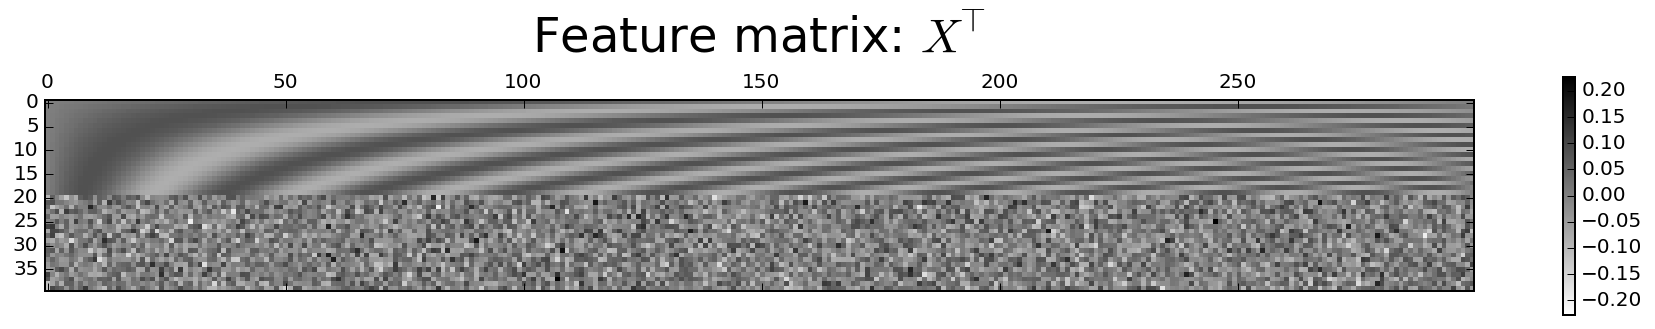

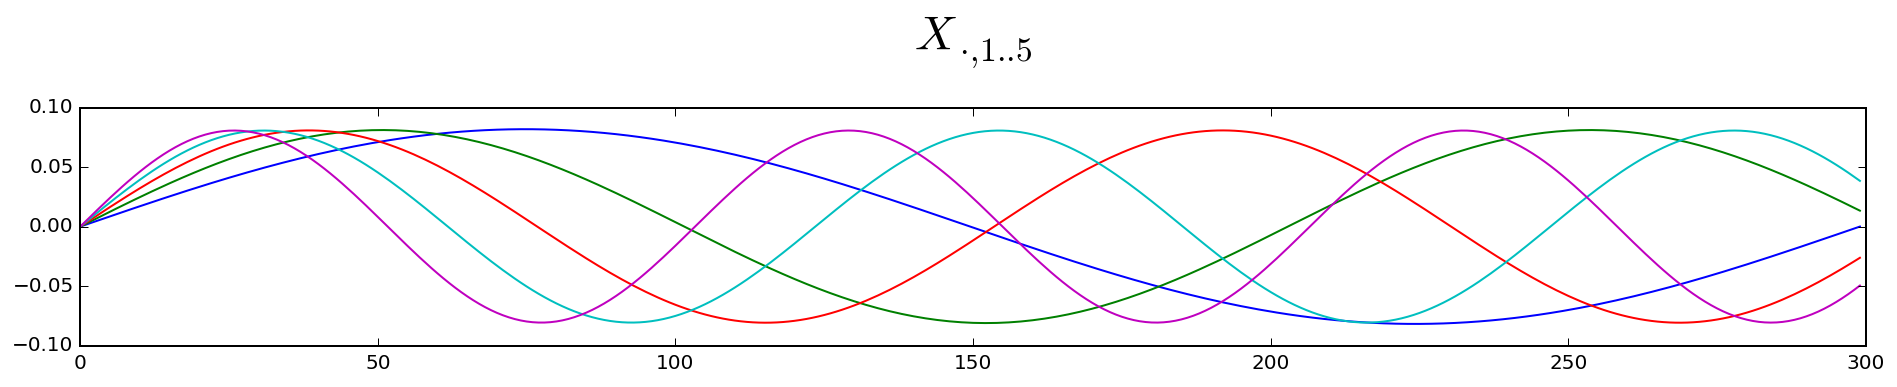

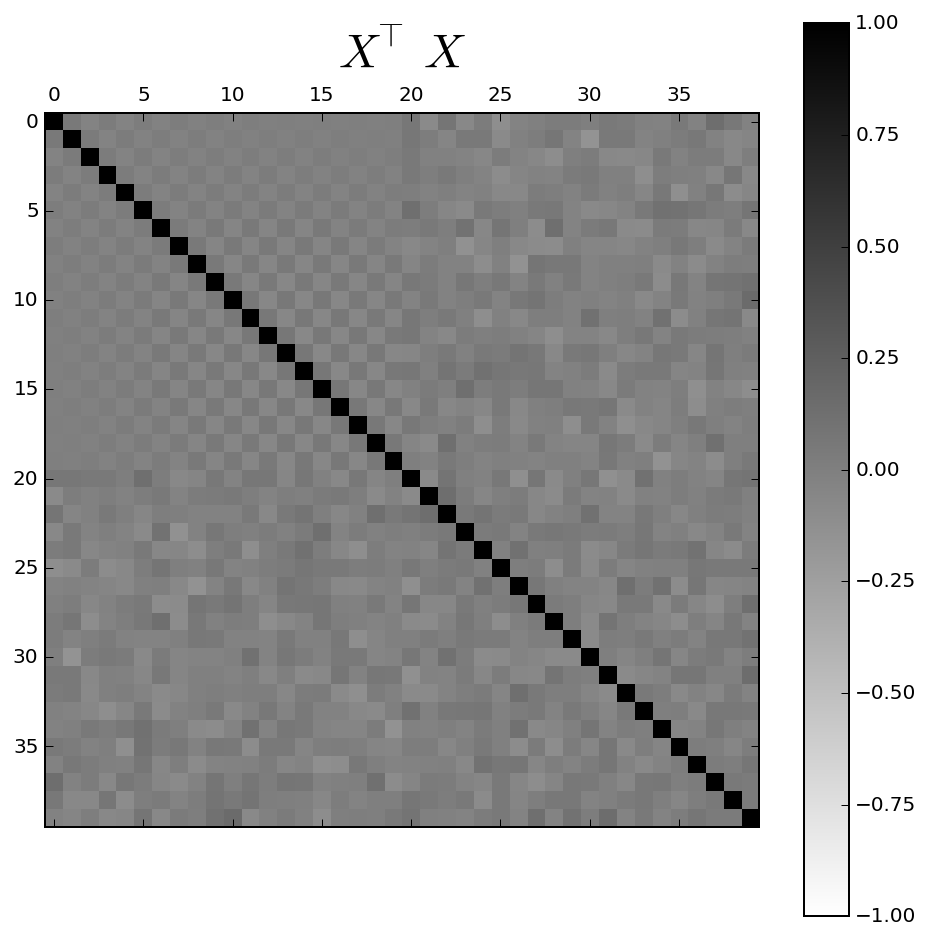

In [19]:
# Show feature matrix
matshow_symm(X.T); colorbar(); rtitle(r"Feature matrix: $X^\top$");

# Plot a few features
figure(figsize=gcf().get_size_inches()); plot(X[:,:5]); rtitle(r"$X_{\cdot,1..5}$")

matshow_symm(np.dot(X.T, X)); colorbar(); title(r"$X^\top X$");
gcf().set_size_inches(8,8)

# Equicorrelated knockoff

In [20]:
# Take SVD of X
U,S,Vh = np.linalg.svd(X, full_matrices=False)

# Create U_perp, "an orthonormal matrix whose column space is orthogonal to that of X"
# by taking "skinny" QR decomposition of U (i.e. padded w/ zeros)
# (from MATLAB code)
Q,R = np.linalg.qr(np.hstack([U, np.zeros_like(X)]))
U_perp = Q[:,p:2*p]

# Confirm orthogonality, i.e. U_perp' . X = 0
print "U_perp' . X = 0:", np.allclose(np.dot(U_perp.T, X), 0)


# Compute s, the amount of direct cross-correlation removed
# i.e. corr( Xj, X~j ) = 1 - s
s = min(2 * S[-1] ** 2, 1.0)
print "s =", s


# Compute first part of knockoff X: X . (I - Sigma^-1 . diag(s)) (2.3)
X_ko_1 = np.dot(np.dot(U, np.diag(S - s/S)), Vh)

# Second part of knockoff X: U~ . C (2.3)
X_ko_2 = np.dot(np.dot(U_perp, np.diag(np.sqrt(2 * s - s ** 2 / S ** 2))), Vh)

# Full knockoff X (2.3)
X_ko = X_ko_1 + X_ko_2

# Confirm properties of X~
# Compute G = autocovariance and cross-covariance of X and X~ (2.1)
G = np.dot(np.hstack([X, X_ko]).T, np.hstack([X, X_ko]))

print "X' . X~ = (X' . X) - diag(s): ", np.allclose(np.dot(X.T, X) - s * np.eye(p), G[p:,:p])

U_perp' . X = 0: True
s = 0.47403240185
X' . X~ = (X' . X) - diag(s):  True


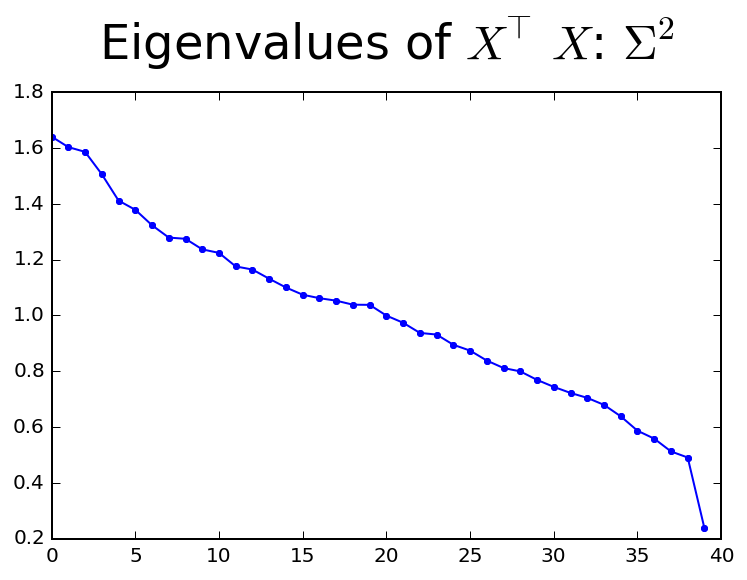

In [21]:
plot(S ** 2, '.-'); 
title(r"Eigenvalues of $X^\top X$: $\Sigma^2$", y=1.05);

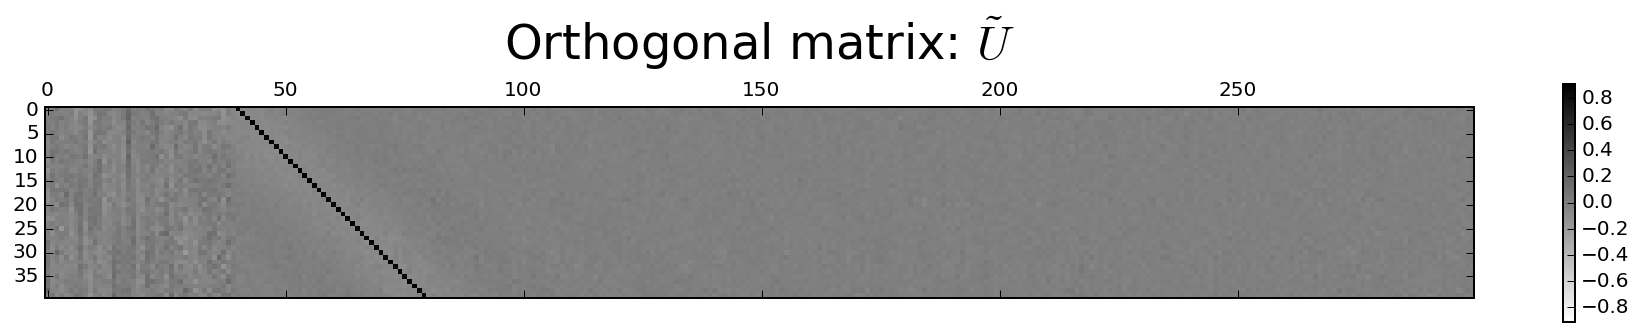

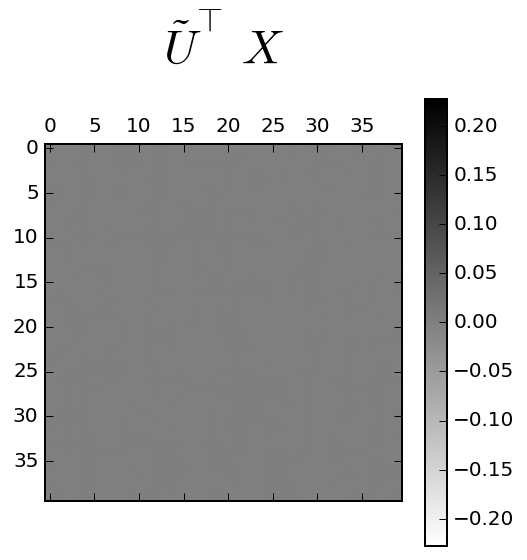

In [22]:
matshow_symm(U_perp.T); colorbar(); 
rtitle("Orthogonal matrix: $\~U$");

xmax = np.abs(X).max()
matshow(np.dot(U_perp.T, X), vmin=-xmax, vmax=xmax); colorbar(); 
rtitle(r"$\~U^\top X$");

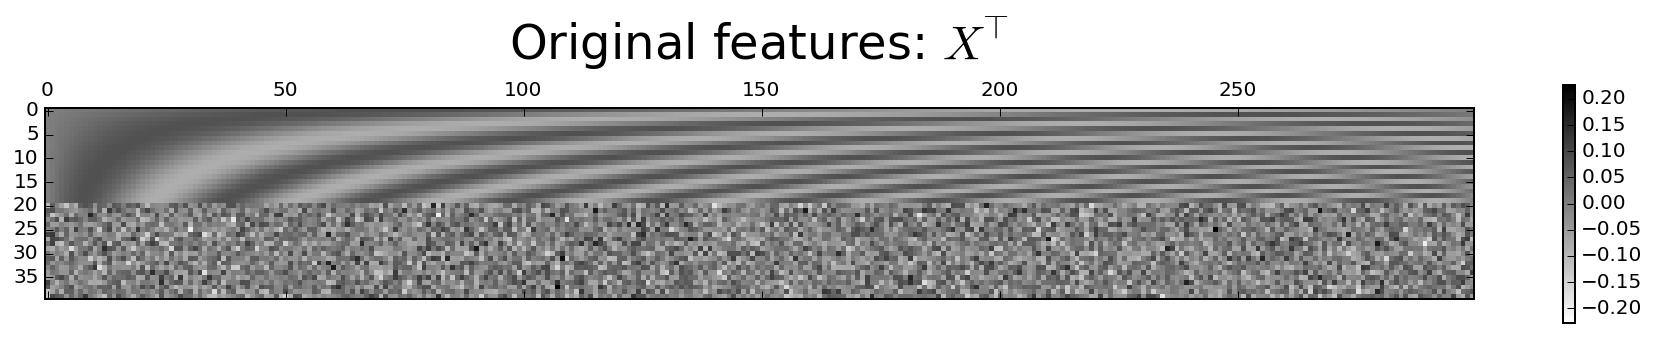

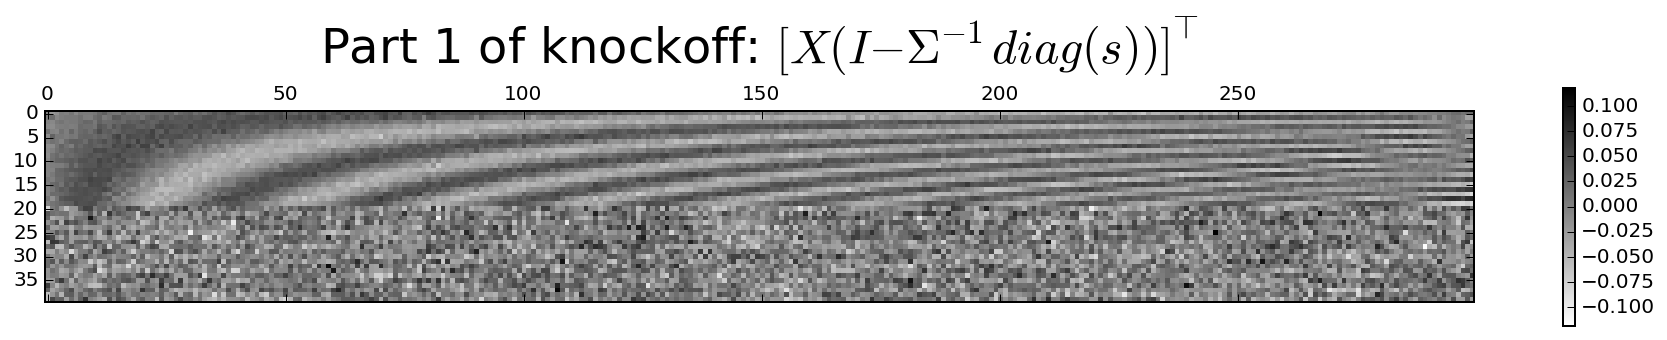

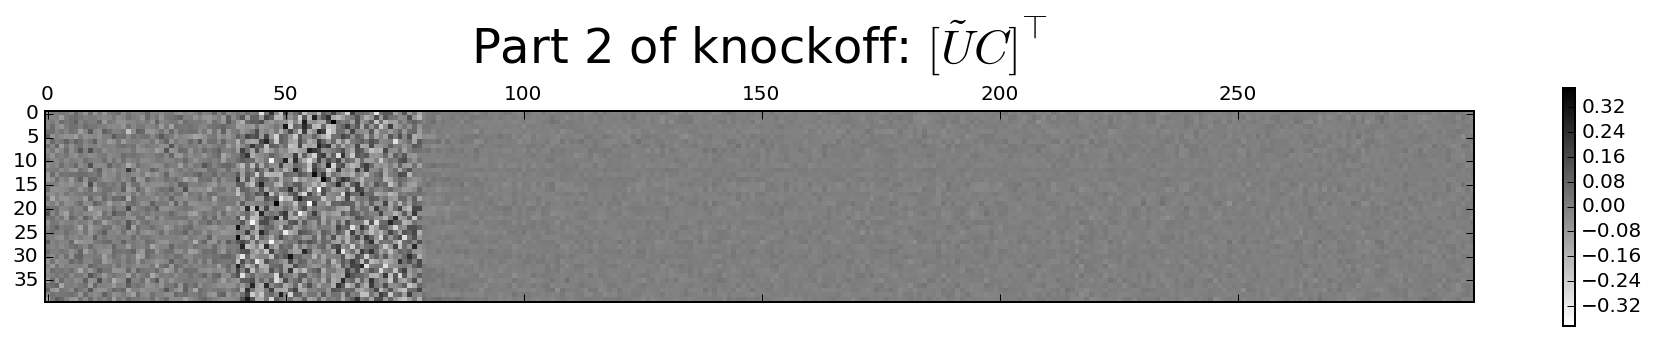

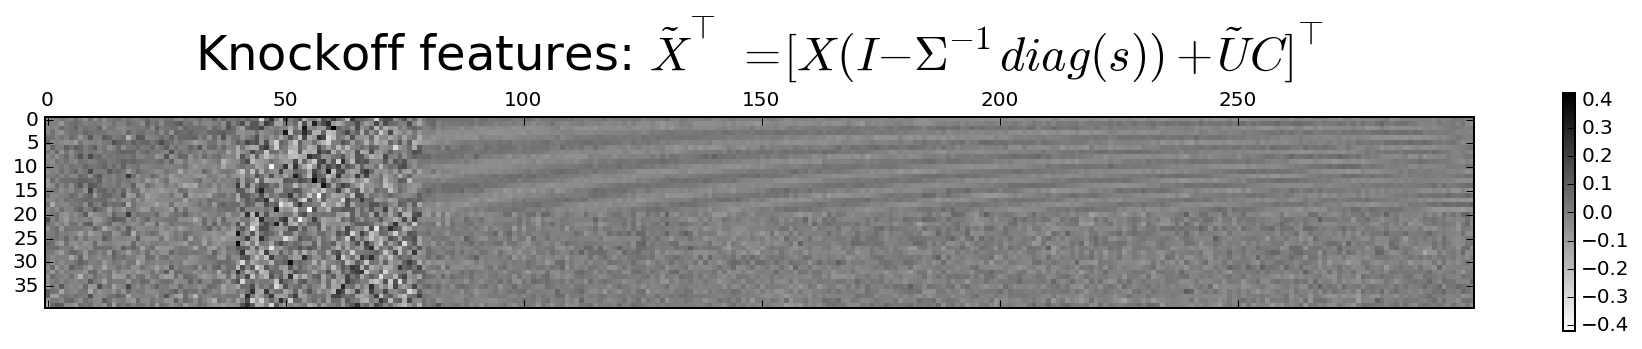

In [23]:
matshow_symm(X.T); colorbar(); 
rtitle(r"Original features: $X^\top$");

matshow_symm(X_ko_1.T); colorbar(); 
rtitle(r"Part 1 of knockoff: $[X(I - \Sigma^{-1} diag(s))]^\top$");

matshow_symm(X_ko_2.T); colorbar(); 
rtitle(r"Part 2 of knockoff: $[\~U C]^\top$")

matshow_symm(X_ko.T); colorbar(); 
rtitle(r"Knockoff features: $\~X^\top = [X(I - \Sigma^{-1} diag(s)) + \~U C]^\top$");

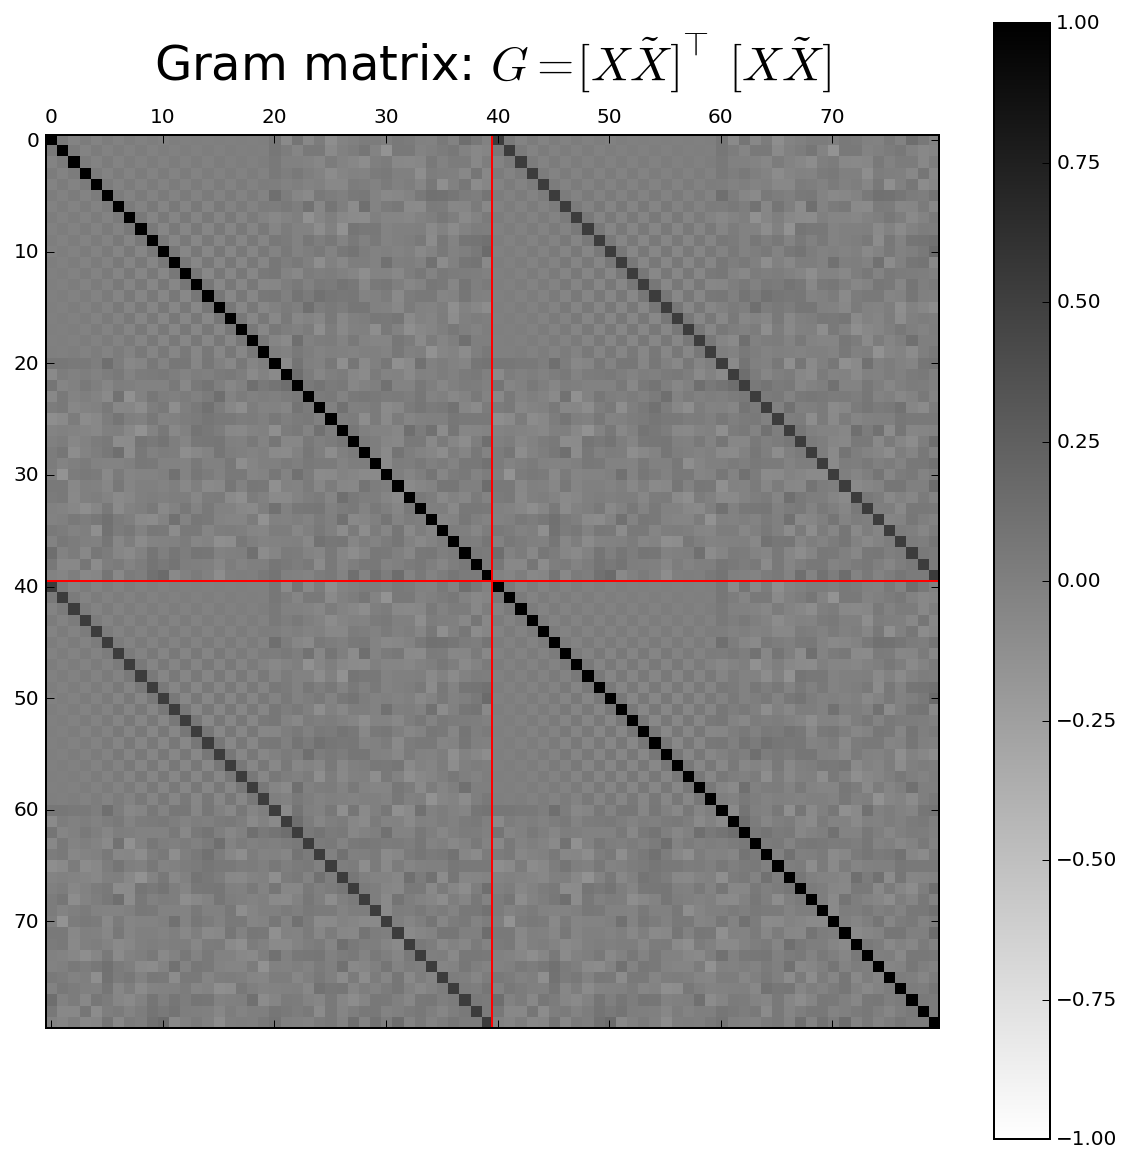

In [24]:
matshow_symm(G); colorbar(); title(r"Gram matrix: $G = [X \~X]^\top [X \~X]$")
gcf().set_size_inches(10,10)
hlines(p-0.5, -0.5, 2*p-0.5, colors='r'); vlines(p-0.5, -0.5, 2*p-0.5, colors='r');

# SDP Knockoff

In [25]:
from cvxopt import matrix, solvers

In [26]:
# Compute Gram matrix and pseudoinverse
Gram = np.dot(np.dot(Vh.T, np.diag(S ** 2)), Vh)
Gram_inv = np.dot(np.dot(Vh.T, np.diag(S ** -2)), Vh)

# Set up semidefinite program (SDP)
c = matrix(-np.ones(p)) # minimize [-1 -1 ...] . x

# -- matrix constraints: diag(x) <= 2 * Gram
h = [matrix(2 * Gram)]
g = [matrix(np.vstack([np.diag(e).reshape(1,-1) for e in np.eye(p)])).T]

# -- element-wise constraints: -x_i <= 0
h0 = matrix(np.zeros(p))
g0 = matrix(-np.eye(p)).T

# Run cvx solver
sol = solvers.sdp(c, Gl=g0, hl=h0, Gs=g, hs=h)
x = np.minimum(np.array(sol["x"]).T[0], 1.0)
print "SDP s mean:", x.mean()
print "equicorrelated s:", s

# Compute knockoff of X with new s values (i.e. x)
dix = np.diag(x)
_, D, Vh2 = np.linalg.svd(2 * dix - np.dot(np.dot(dix, Gram_inv), dix))
d = np.sqrt(np.maximum(0, D))
did = np.diag(d)

sX_ko_1 = reduce(np.dot, [X, Gram_inv, dix])
sX_ko_2 = reduce(np.dot, [U_perp, did, Vh2])
sX_ko = X - sX_ko_1 + sX_ko_2

# Confirm properties of X~
# Compute G = autocovariance and cross-covariance of X and X~ (2.1)
sG = np.dot(np.hstack([X, sX_ko]).T, np.hstack([X, sX_ko]))

print "X' . X~ = (X' . X) - diag(s): ", np.allclose(np.dot(X.T, X) - x * np.eye(p), sG[p:,:p])

     pcost       dcost       gap    pres   dres   k/t
 0: -4.0000e+01 -1.6000e+02  3e+02  1e+00  2e-16  1e+00
 1: -5.1488e+01 -1.0809e+02  1e+02  5e-01  1e-15  1e+00
 2: -4.5552e+01 -9.3280e+01  1e+02  4e-01  1e-15  1e+00
 3: -3.4365e+01 -4.7997e+01  3e+01  1e-01  1e-15  5e-01
 4: -3.3887e+01 -3.5927e+01  3e+00  2e-02  2e-15  7e-02
 5: -3.3624e+01 -3.4267e+01  1e+00  6e-03  1e-15  2e-02
 6: -3.3455e+01 -3.3549e+01  1e-01  8e-04  1e-15  3e-03
 7: -3.3429e+01 -3.3460e+01  5e-02  3e-04  6e-16  8e-04
 8: -3.3418e+01 -3.3421e+01  5e-03  3e-05  1e-15  8e-05
 9: -3.3417e+01 -3.3417e+01  6e-04  3e-06  1e-15  9e-06
10: -3.3416e+01 -3.3416e+01  1e-04  8e-07  1e-15  2e-06
11: -3.3416e+01 -3.3416e+01  6e-06  3e-08  9e-16  8e-08
Optimal solution found.
SDP s mean: 0.734753859386
equicorrelated s: 0.47403240185
X' . X~ = (X' . X) - diag(s):  True


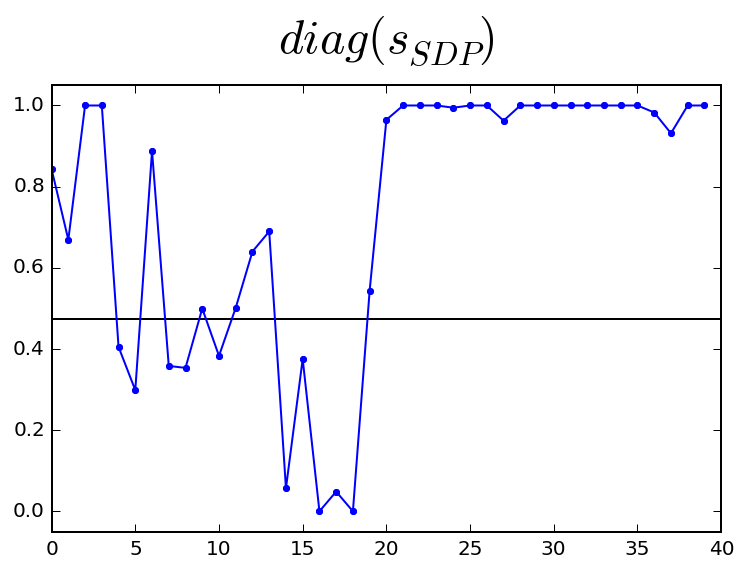

In [27]:
# x (or s_{SDP}) is how much correlation is removed for each feature channel
plot(x, '.-'); ylim(-0.05, 1.05); title("$diag(s_{SDP})$", y=1.05);

# this is how much was removed for all channels in equicorrelated case
hlines(s, 0, p);

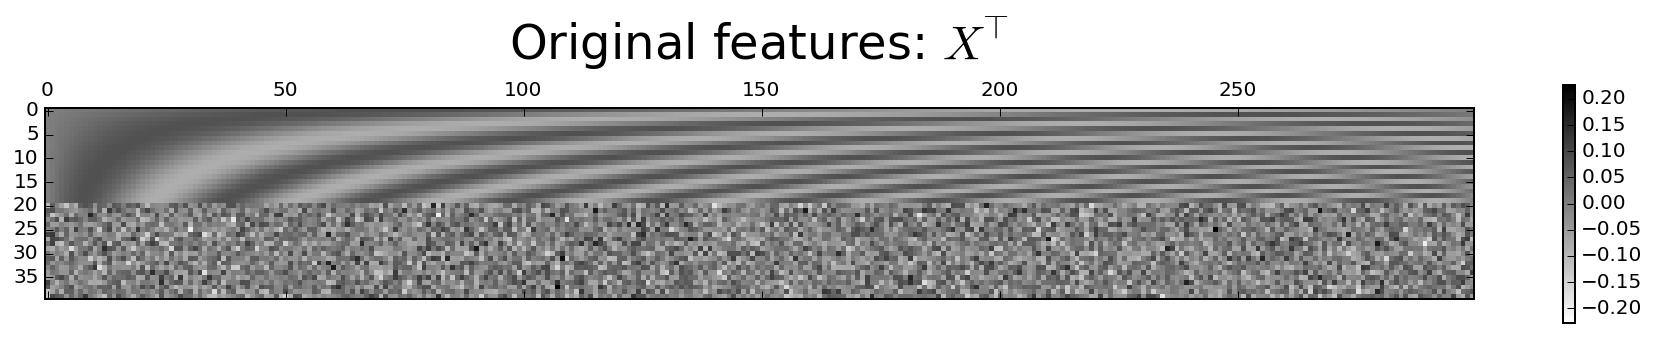

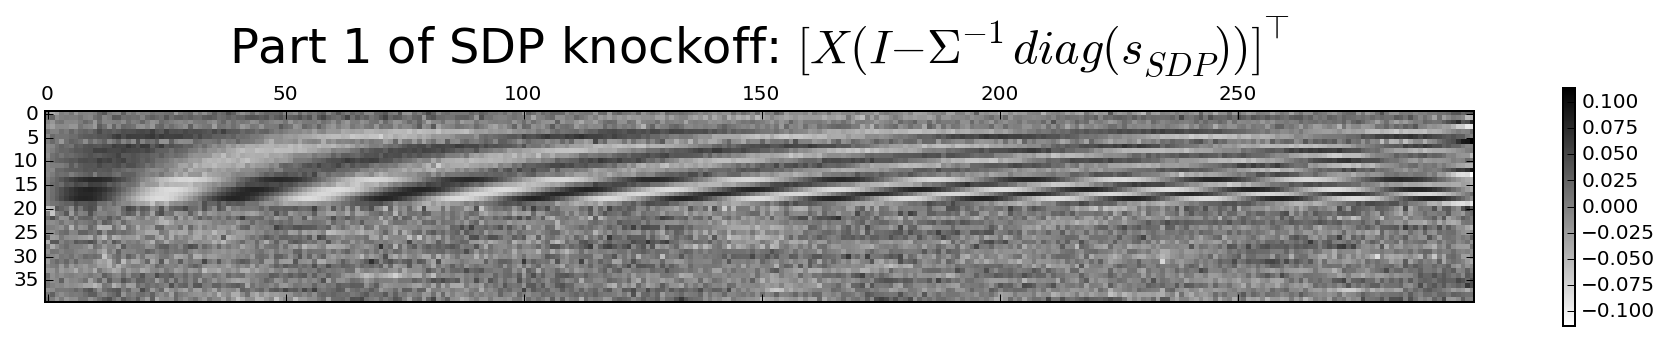

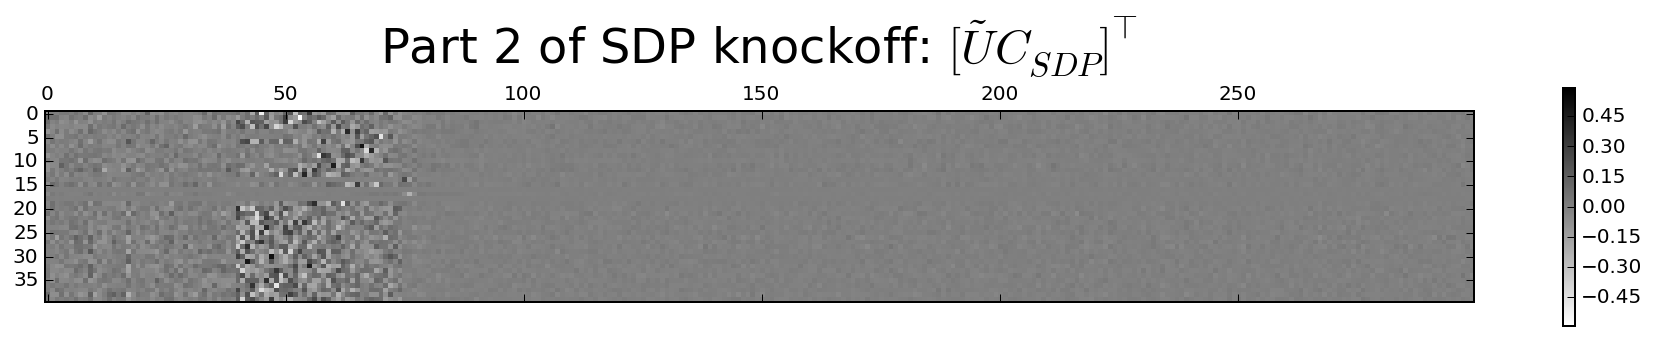

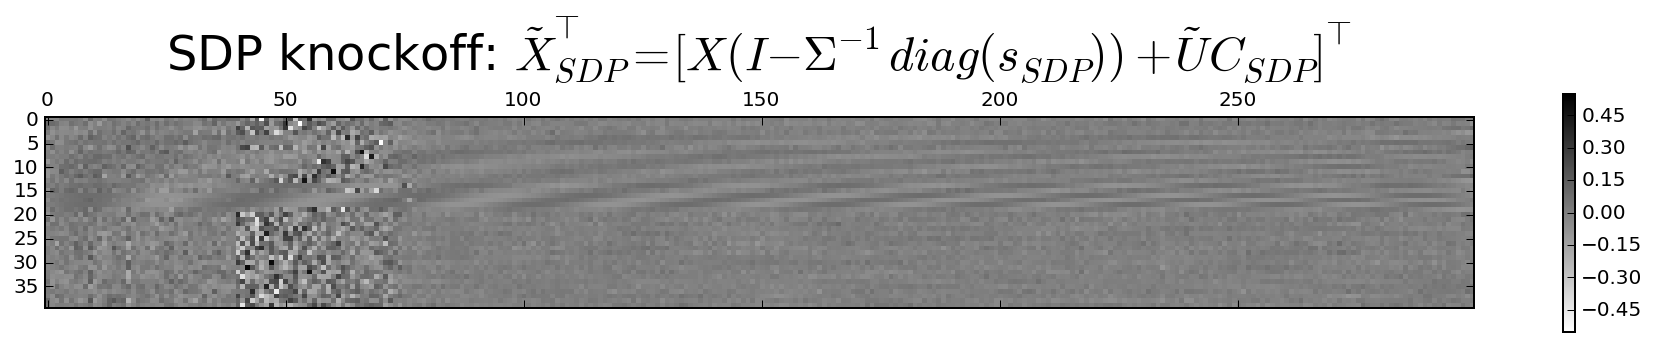

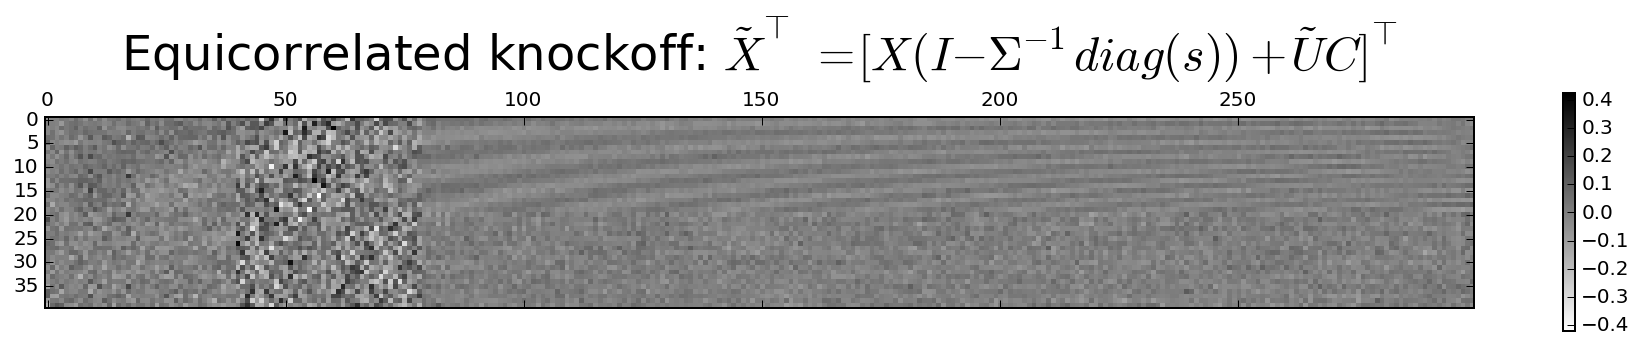

In [28]:
matshow_symm(X.T); colorbar(); rtitle(r"Original features: $X^\top$")

matshow_symm(X.T - sX_ko_1.T); colorbar(); 
rtitle(r"Part 1 of SDP knockoff: $[X(I - \Sigma^{-1} diag(s_{SDP}))]^\top$");

matshow_symm(sX_ko_2.T); colorbar(); 
rtitle(r"Part 2 of SDP knockoff: $[\~U C_{SDP}]^\top$")

matshow_symm(sX_ko.T); colorbar()
rtitle(r"SDP knockoff: $\~X^\top_{SDP} = [X(I - \Sigma^{-1} diag(s_{SDP})) + \~U C_{SDP}]^\top$");

matshow_symm(X_ko.T); colorbar(); 
rtitle(r"Equicorrelated knockoff: $\~X^\top = [X(I - \Sigma^{-1} diag(s)) + \~U C]^\top$");

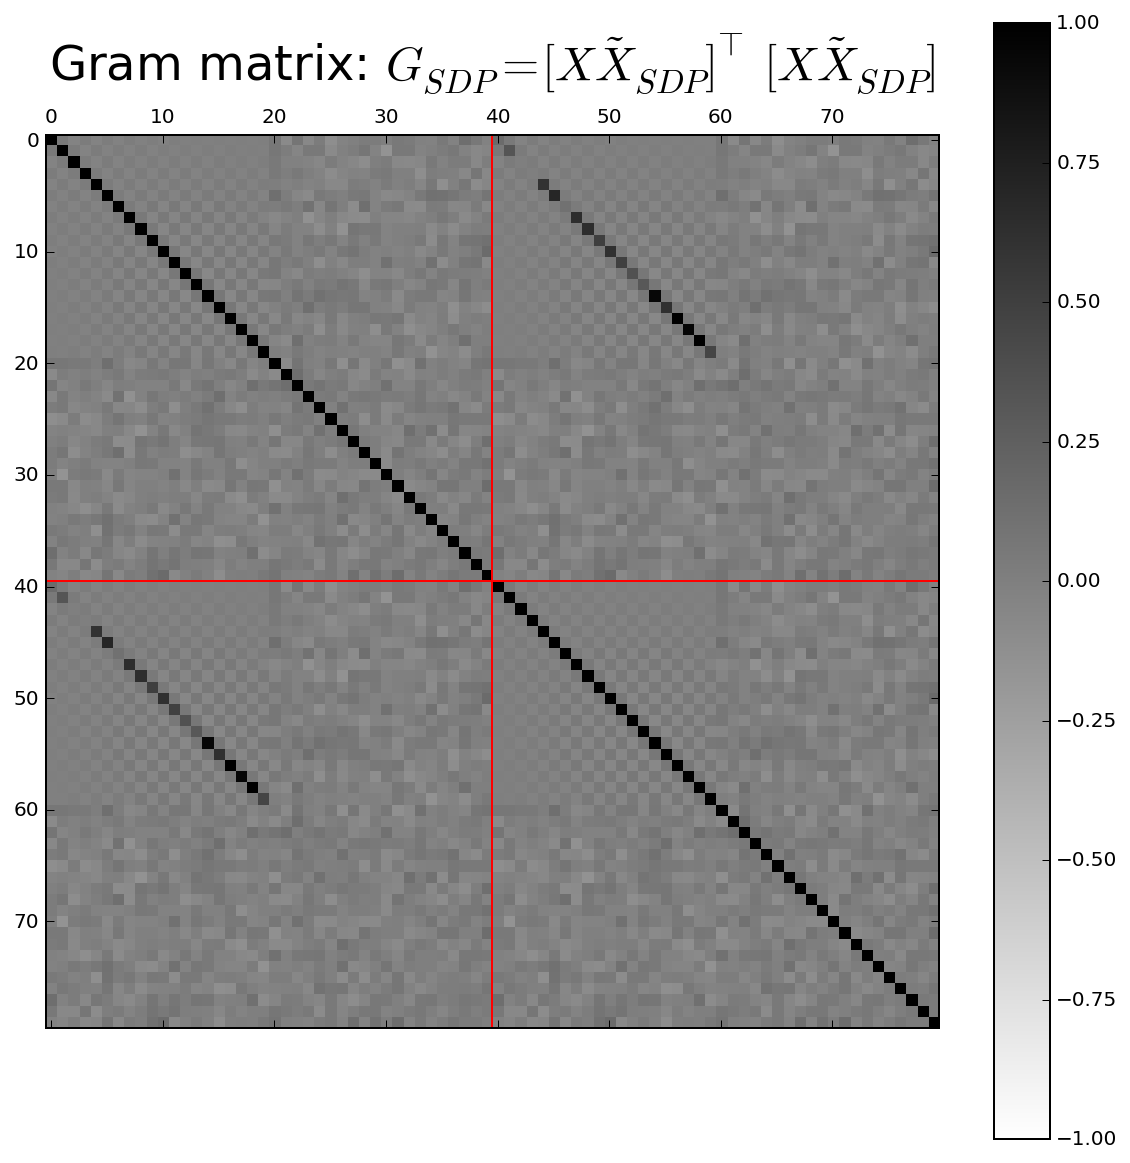

In [29]:
matshow_symm(sG); colorbar(); 
title(r"Gram matrix: $G_{SDP} = [X \~X_{SDP}]^\top [X \~X_{SDP}]$")
gcf().set_size_inches(10,10)
hlines(p-0.5, -0.5, 2*p-0.5, colors='r'); vlines(p-0.5, -0.5, 2*p-0.5, colors='r');